# **Object Detection using Faster R-CNN**

**Hi everyone!**

In this notebook, I will show you how we can train and finetune Faster R-CNN and Mask R-CNN models for object detection of fruit image detection dataset. If you want to brush up about what is Faster RCNN, [here](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) is an awesome medium article on the same.

## Install Libraries

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory



In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 30359, done.
remote: Counting objects: 100% (2901/2901), done.
remote: Compressing objects: 100% (705/705), done.
remote: Total 30359 (delta 2213), reused 2773 (delta 2139), pack-reused 27458
Receiving objects: 100% (30359/30359), 38.23 MiB | 31.65 MiB/s, done.
Resolving deltas: 100% (22828/22828), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cv2
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# As the data directory contains .xml files
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# defining the files directory and testing directory
files_dir = '../input/fruit-images-for-object-detection/train_zip/train'
test_dir = '../input/fruit-images-for-object-detection/test_zip/test'

# Faster R-CNN

## Loading the dataset

In [ ]:
class FruitImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms  # If transformation is required, when transforms is not None
        
        self.classes_ = [_, 'apple', 'orange', 'banana']  # Defining classes, a blank class is given for the background
        
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

In [ ]:
# Observing the dataset without any transformation
dataset = FruitImageDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



## Observing and Visualizing the bounding boxes

In [ ]:
img, target = dataset[78]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'labels': tensor([3, 3, 3, 3]), 'iscrowd': tensor([0, 0, 0, 0]), 'img_id': tensor([78])}


Above we can see the image at the 78th index comprises of 4 boxes

In [ ]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

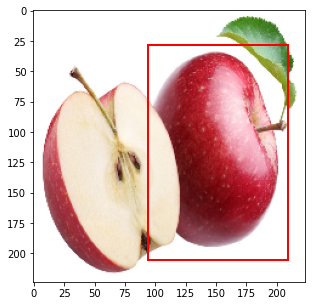

In [ ]:
img, target = dataset[25]
plot_img_bbox(img, target)

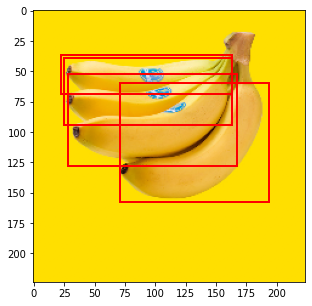

In [ ]:
img, target = dataset[78]
plot_img_bbox(img, target)

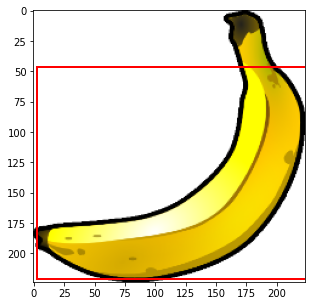

In [ ]:
img, target = dataset[120]
plot_img_bbox(img, target)

## Model Development

### Initializing the model

We may use both the models that is **Faster R-CNN** or **Mask R-CNN** and compare which model gives us a better **Average Precision (AP)**. If possible, we can also try out making an ensemble of the 2 models. 

In [ ]:
def get_model(num_classes, modelName):
    
    # Loading the pre-trained model
    if modelName == 'fastcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model
    
    elif modelName == 'maskcnn':
        model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

### Data Augmentaion

The process for augmenting the data for object detection is different from object classification as we need to ensure that the final bounding box still aligns with the object after transforming. 

In [ ]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Dataset Preparation

In [ ]:
test_split = 0.2

# Loading the training and the testing data with all tghe transformations
dataset_train = FruitImageDataset(files_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = FruitImageDataset(files_dir, 480, 480, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Train test split
tsize = int(len(dataset) * test_split) # Getting the splitting index
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)

## Model Training
### Model Configuration

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4 # Can try by changing to 3 as 1 class is devoted for background
num_epochs = 9

def start_training(modelName, num_epochs, num_classes):
    model = get_model(num_classes, modelName)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)
    
    # Learning rate decreases by 10 every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=5)
        lr_scheduler.step()
        evaluate(model, dataloader_test, device=device)
    return model

In [ ]:
fast_rcnn = start_training('fastcnn', num_epochs, num_classes)

Epoch: [0]  [ 0/24]  eta: 0:00:49  lr: 0.000222  loss: 2.1865 (2.1865)  loss_classifier: 1.7611 (1.7611)  loss_box_reg: 0.4106 (0.4106)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 2.0782  data: 0.7704  max mem: 10849
Epoch: [0]  [ 5/24]  eta: 0:00:26  lr: 0.001308  loss: 1.4918 (1.6104)  loss_classifier: 1.2127 (1.2618)  loss_box_reg: 0.2761 (0.3348)  loss_objectness: 0.0051 (0.0071)  loss_rpn_box_reg: 0.0055 (0.0067)  time: 1.3851  data: 0.1497  max mem: 11117
Epoch: [0]  [10/24]  eta: 0:00:18  lr: 0.002394  loss: 0.9549 (1.2035)  loss_classifier: 0.6297 (0.8779)  loss_box_reg: 0.2761 (0.3110)  loss_objectness: 0.0071 (0.0075)  loss_rpn_box_reg: 0.0055 (0.0072)  time: 1.3212  data: 0.0900  max mem: 11117
Epoch: [0]  [15/24]  eta: 0:00:11  lr: 0.003480  loss: 0.6133 (0.9877)  loss_classifier: 0.3904 (0.6949)  loss_box_reg: 0.2505 (0.2798)  loss_objectness: 0.0051 (0.0065)  loss_rpn_box_reg: 0.0052 (0.0066)  time: 1.3012  data: 0.0705  max mem: 11117
Epoc

We have achieved an **Average Precision (AP)** of **0.940**.

## Decoding Predictions

If and when a model predicts many bounding boxes for a single object, we apply **Non Max Supression** to take out the overlapping boxes. <br>
We will be using torchvision's 'nms' method to do so.

In [ ]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

## Fast R-CNN model testing

In [ ]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  6
real #boxes:  1


We received an output that our model  returns 5 boxes extra in the test image at index 5 

EXPECTED OUTPUT


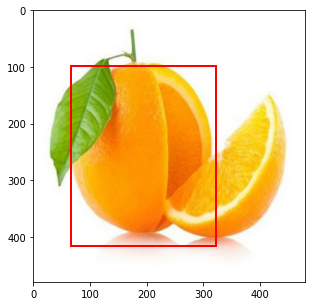

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

MODEL OUTPUT


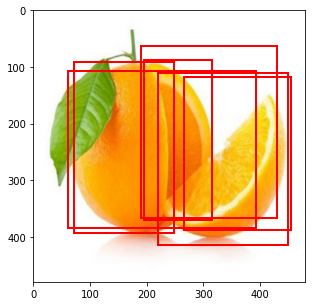

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

We can observe that our model did return 6 boxes instead of 1.

#### Let's apply NMS

NMS APPLIED MODEL OUTPUT


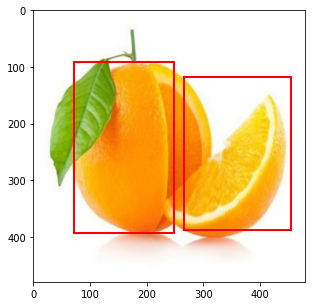

In [ ]:
nms_preds = apply_nms(prediction, threshold=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), nms_preds)

We can observe that after applying Non Max Supression, out model returns precisely 2 boxes, whereas in real XML, it was 1. Our model predicts 2 boxes as we can see in the image that there are 2 pieces of the same fruit.

EXPECTED OUTPUT



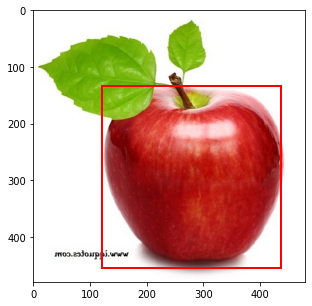

MODEL OUTPUT



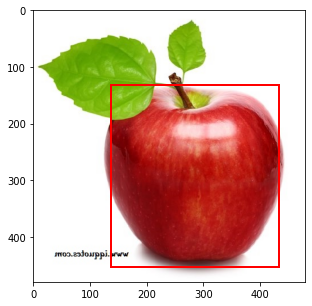

In [ ]:
test_dataset = FruitImageDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, threshold=0.01)

plot_img_bbox(tensorToPIL(img), nms_prediction)

## Model Architecture

In [ ]:
fast_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

Our model is predicting slices as well, therefore, there is room for improvement. <br>
1. Extensive use of Albumentations.
2. Modifying the Optimizer
3. Modufying the Learning Rate scheduler.
4. Changing the size of the images.
5. Changing the backbone of the model.
6. Using AutoAlbumentations

# Thank You!
## The END!

### Do Upvote this notebook